# A simplified CenterNet architecture for keypoint detection

# Imports

In [6]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import torch.optim as optim

from torchvision.models import resnet18, ResNet18_Weights

assert torch.cuda.is_available()

In [7]:
input_width = 1920
input_height = 1080

MODEL_SCALE = 32

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 2

# I found that 20 keypoints was enough for my application, dont hesitate to change it if you need
NB_POINTS = 20

In [8]:
COLORS = []
for red in [0, 128, 255]:
    for green in [0, 128, 255]:
        for blue in [0, 128, 255]:
            COLORS.append((red, green, blue))

COLORS = COLORS[1:]

# Load dataset

Image frame_203.png
Image shape = (1080, 1920, 3)


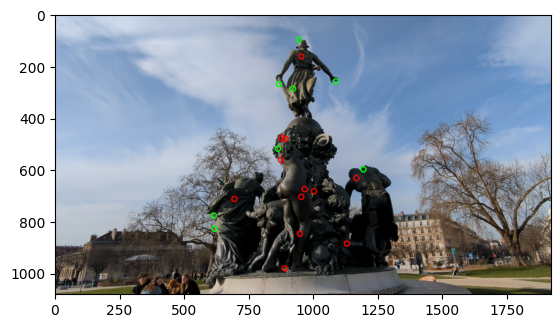

In [9]:
dataset_folder = "nation/images/"
labels_file = "nation/keypoints.json"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder, IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(labels_file) as f:
    labels = json.load(f)
    
# Load labels
keypoints = labels[IMAGE]

print(f"Image shape = {img.shape}")

for keypoint in keypoints:
    cv2.circle(img, (int(keypoint[0]), int(keypoint[1])), radius=10, color=(0, 255, 0) if keypoint[2] == 1.0 else (255,0,0), thickness=3)

plt.imshow(img)
plt.show()

# Utility functions

Let's plot center points into the image.

In [10]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [11]:
# Heatmap function

def make_hm(target):
    hm = np.zeros([NB_POINTS, input_height//MODEL_SCALE + 1, input_width//MODEL_SCALE])
    offset = np.zeros([NB_POINTS, 2, input_height//MODEL_SCALE + 1, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    i = 0
    for _, c in target.iterrows():
        if c["visible"]:
            hm[i] = draw_msra_gaussian(hm[i], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                    sigma=0.5) # CHANGED SIGMA!!!
            offset[i] = draw_offset(offset[i], c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)

        i+= 1
        
    return hm, offset

In [12]:
def pred2point(hm, offset, thresh=0.99):
    """
    Based on the heatmap, find objects with thresholding
    then refine to exact location with the offset maps.
    We return points as pixel along with confidence scores
    """
    nb_points = hm.shape[0]
    
    points = [ [] for _ in range(nb_points) ]
    scores = [ [] for _ in range(nb_points) ]

    for i in range(nb_points):
    
        # get centers
        pred = hm[i] > thresh
        pred_centers = np.argwhere(pred)
        scores[i] = hm[i][pred]
        
        for center, score in zip(pred_centers, scores):
            arr = np.array([center[1], center[0]]+offset[i, :, center[0], center[1]])*MODEL_SCALE
            points[i].append(arr)

    return points, scores

In [13]:
def show_point(img, hm, offset, thresh=0.9):
    """Draw circles around detections"""
    
    points, scores = pred2point(hm, offset, thresh=thresh)

    nb_points = len(points)

    assert nb_points == NB_POINTS

    for i in range(nb_points):
        color = COLORS[i % len(COLORS)]
        for point in points[i]:
            cv2.circle(img,
                          center=(round(point[0]), round(point[1])),
                          radius=10,
                          color=color, thickness=4)
            
    return img


# Make Pytorch dataset with dataloader

In [14]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder)), test_size=0.2, random_state=777)

In [15]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class KeyPointsDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, train=False):
        self.train = train
        self.img_id = img_id
        keypoints_dict = []
        
        for img_name in self.img_id:
            keypoints = labels[img_name]
            for keypoint in keypoints:
                keypoints_dict.append({"image": img_name[:-4], "y": keypoint[1], "x": keypoint[0], "visible": keypoint[2] == 1.0})

        self.labels = pd.DataFrame.from_dict(keypoints_dict)
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(dataset_folder, self.img_id[idx]))
        target = self.labels[self.labels['image']==self.img_id[idx][:-4]]
        
        if self.train:
            angle = 0.0 #np.random.uniform(low=-60.0, high=60.0)
            image_center = tuple(np.array(img.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            img = cv2.warpAffine(
                img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR
            )
            xy = np.array(target[["x", "y"]])
            
            correct = (rot_mat[:2,:2].dot(xy.T) + rot_mat[:, 2].reshape(2, 1)).T
            for i, (index, row) in enumerate(target.iterrows()):
                target.at[index, "x"] = correct[i][0]
                target.at[index, "y"] = correct[i][1]
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_preprocessed = self.normalize(img)
        img_preprocessed = img_preprocessed.transpose([2,0,1])
        hm, offset = make_hm(target)
        return img, img_preprocessed, hm, offset


In [16]:
traindataset = KeyPointsDataset(train_id, train=True)
valdataset = KeyPointsDataset(test_id)

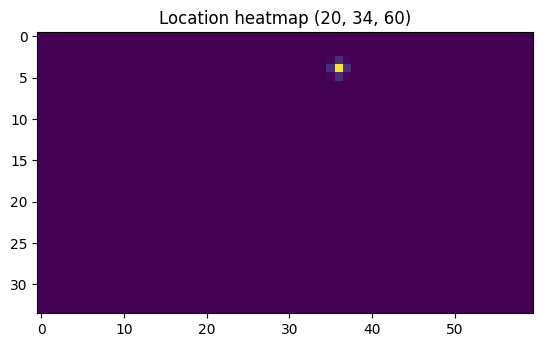

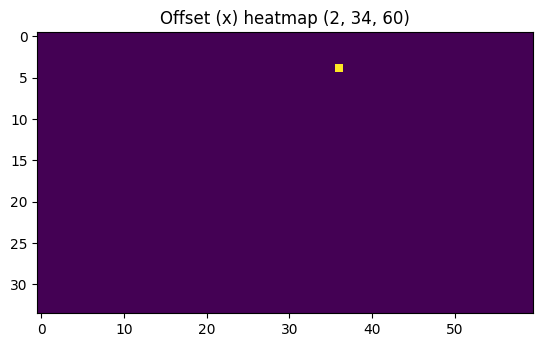

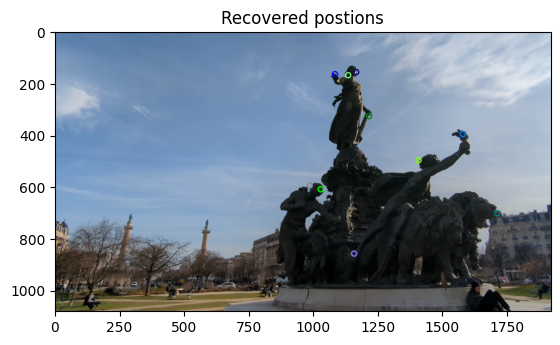

In [18]:
# Check traindataset
k = random.randint(0, len(train_id))
img, img_preprocessed, hm, offset = traindataset[k]

plt.imshow(hm[0])
plt.title(f"Location heatmap {hm.shape}")
plt.show()

plt.imshow(offset[0, 0,:,:])
plt.title(f"Offset (x) heatmap {offset[0].shape}")
plt.show()

img = show_point(img, hm, offset, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [19]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True)

## Define Centernet model

In [26]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Select only first layers up when you reach 160x90 dimensions with 128 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])
    
        num_ch = 512
        head_conv = 64

        # define outc and outo for each keypoint
        for i in range(NB_POINTS):
            setattr(self, f"outc_{i}", nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1)))
            setattr(self, f"outo_{i}", nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1)))
            
        
    def forward(self, x):
        x = self.base_model(x)
        
        assert not torch.isnan(x).any()

        outc = torch.zeros((x.size(0), NB_POINTS, 1, x.size(2), x.size(3)), device=x.device)
        outo = torch.zeros((x.size(0), NB_POINTS, 2, x.size(2), x.size(3)), device=x.device)

        for i in range(NB_POINTS):
            outc[:, i, :, :, :] = getattr(self, f"outc_{i}")(x)
            outo[:, i, :, :, :] = getattr(self, f"outo_{i}")(x)

        return outc, outo

In [27]:
model = centernet()
# Check if it runs correctly
output = model(torch.rand(2,3,input_height,input_width))
print(output[0].size())
print(output[1].size())

torch.Size([2, 20, 1, 34, 60])
torch.Size([2, 20, 2, 34, 60])


In [28]:
summary(model, (1, 3, input_height, input_width))

Layer (type:depth-idx)                        Output Shape              Param #
centernet                                     [1, 20, 1, 34, 60]        --
├─Sequential: 1-1                             [1, 512, 34, 60]          --
│    └─Conv2d: 2-1                            [1, 64, 540, 960]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 540, 960]         128
│    └─ReLU: 2-3                              [1, 64, 540, 960]         --
│    └─MaxPool2d: 2-4                         [1, 64, 270, 480]         --
│    └─Sequential: 2-5                        [1, 64, 270, 480]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 270, 480]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 270, 480]         73,984
│    └─Sequential: 2-6                        [1, 128, 135, 240]        --
│    │    └─BasicBlock: 3-3                   [1, 128, 135, 240]        230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 135, 240]        295,42

# Define Loss (Focal loss + L1-loss)

In [30]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds 
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights 
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _reg_loss(regr, gt_regr, hm_gt):
    
    mask = hm_gt.float().ge(1.0).float()

    mask = mask.unsqueeze(2)
    
    num = mask.float().sum() 
    mask = mask.expand_as(gt_regr).float()
    
    assert regr.size() == mask.size()
    regr = regr * mask
    gt_regr = gt_regr * mask

    regr_loss = nn.functional.l1_loss(regr, gt_regr, reduction='sum')
    
    regr_loss = regr_loss / (num + 1e-4)
    return regr_loss

def global_loss(hm_pred, hm_gt, regr_pred, regr_gt):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """

    pred_mask = torch.sigmoid(hm_pred)
  
    pred_mask = pred_mask.float()

    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)

    off_loss = _reg_loss(regr_pred, regr_gt, hm_gt)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss

# Training

In [33]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img_orig, img, hm, offset) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        # set opt
        optimizer.zero_grad()

        # run model
        preds_hm, preds_offset = model(img)

        preds_hm = preds_hm.squeeze(2)
        preds_offset = preds_offset.squeeze(1).squeeze(1)
        offset_gt = offset_gt.squeeze(1)
            
        foc_loss, pos_loss, neg_loss, off_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt)
        loss = foc_loss + off_loss
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f})')
    
    scheduler.step()
    
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img_orig, img, hm, offset) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)

            # run model
            preds_hm, preds_offset = model(img)

            preds_hm = preds_hm.squeeze(2)
            # hm_gt = hm_gt.squeeze(1)
            preds_offset = preds_offset.squeeze(1).squeeze(1)
            offset_gt = offset_gt.squeeze(1)
            # print(preds_hm.size(), hm_gt.size(), preds_offset.size(), offset_gt.size())

            foc_loss, pos_loss, neg_loss, off_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt)
            
            loss = foc_loss + off_loss
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [36]:
model = centernet()
# model.load_state_dict(torch.load("keypoints.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

logs = []
best_loss = float('inf')

In [37]:
epochs = 10

for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "keypoints.pth")   


epochs 1/10
Learning rate : 0.0001


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.92it/s]


train loss : 35.1198
Pos loss : 4.5085
Neg loss : 30.0417
Off loss : 0.5697

Val loss : 4.4600
Val Pos loss : 3.2737
Val Neg loss : 0.7424
Val Off loss : 0.4438
Improved validation loss to 4.460
epochs 2/10
Learning rate : 0.0001


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


train loss : 3.3171
Pos loss : 2.3171
Neg loss : 0.6227
Off loss : 0.3773

Val loss : 2.6376
Val Pos loss : 1.7531
Val Neg loss : 0.5251
Val Off loss : 0.3594
Improved validation loss to 2.638
epochs 3/10
Learning rate : 0.0001


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.95it/s]


train loss : 2.0829
Pos loss : 1.2775
Neg loss : 0.4888
Off loss : 0.3167

Val loss : 1.9264
Val Pos loss : 1.1703
Val Neg loss : 0.4265
Val Off loss : 0.3296
Improved validation loss to 1.926
epochs 4/10
Learning rate : 0.0001


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


train loss : 1.5179
Pos loss : 0.8581
Neg loss : 0.3960
Off loss : 0.2639

Val loss : 1.5529
Val Pos loss : 0.9265
Val Neg loss : 0.3549
Val Off loss : 0.2715
Improved validation loss to 1.553
epochs 5/10
Learning rate : 0.0001


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


train loss : 1.1819
Pos loss : 0.6206
Neg loss : 0.3275
Off loss : 0.2339

Val loss : 1.2718
Val Pos loss : 0.7059
Val Neg loss : 0.3262
Val Off loss : 0.2396
Improved validation loss to 1.272
epochs 6/10
Learning rate : 5e-05


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


train loss : 0.9220
Pos loss : 0.4726
Neg loss : 0.2680
Off loss : 0.1814

Val loss : 1.1741
Val Pos loss : 0.7144
Val Neg loss : 0.2588
Val Off loss : 0.2010
Improved validation loss to 1.174
epochs 7/10
Learning rate : 5e-05


100%|█████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


train loss : 0.7930
Pos loss : 0.3988
Neg loss : 0.2338
Off loss : 0.1603

Val loss : 1.1170
Val Pos loss : 0.6662
Val Neg loss : 0.2470
Val Off loss : 0.2039
Improved validation loss to 1.117
epochs 8/10
Learning rate : 5e-05


100%|█████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.91it/s]


train loss : 0.6941
Pos loss : 0.3374
Neg loss : 0.2047
Off loss : 0.1520

Val loss : 1.0753
Val Pos loss : 0.6782
Val Neg loss : 0.2043
Val Off loss : 0.1928
Improved validation loss to 1.075
epochs 9/10
Learning rate : 5e-05


100%|█████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


train loss : 0.6201
Pos loss : 0.2930
Neg loss : 0.1794
Off loss : 0.1476

Val loss : 1.0275
Val Pos loss : 0.6257
Val Neg loss : 0.2073
Val Off loss : 0.1944
Improved validation loss to 1.027
epochs 10/10
Learning rate : 5e-05


100%|█████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


train loss : 0.5474
Pos loss : 0.2504
Neg loss : 0.1517
Off loss : 0.1454

Val loss : 1.0069
Val Pos loss : 0.5974
Val Neg loss : 0.2178
Val Off loss : 0.1917
Improved validation loss to 1.007


# Show predictions

torch.Size([1, 20, 1, 34, 60])
(20, 34, 60)


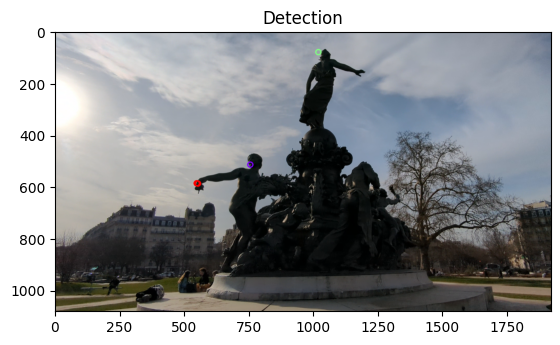

torch.Size([1, 20, 1, 34, 60])
(20, 34, 60)


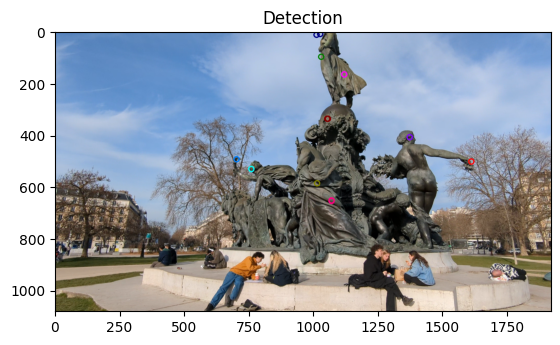

In [40]:
model.load_state_dict(torch.load("keypoints.pth"))
model.eval()

threshold = 0.5

for id in range(2):
    img_orig, img, hm_gt, offset_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset = model(img.to(device).float().unsqueeze(0))

    print(hm.size())
    
    hm = hm.cpu().numpy().squeeze(0).squeeze(1)
    print(hm.shape)
    
    offset = offset.cpu().numpy().squeeze(0)

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    
    # plt.imshow(hm[0]>threshold)
    # plt.title(f"Heatmap 0 > {threshold}")
    # plt.show()

    # plt.imshow(hm[1]>threshold)
    # plt.title(f"Heatmap 1 > {threshold}")
    # plt.show()
    
    
    # plt.imshow(offset[0][0])
    # plt.title("Offset heatmap (x)")
    # plt.show()
    
    sample = show_point(img_orig, hm, offset, threshold)
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()

# Export predictions

In [42]:
model.load_state_dict(torch.load("keypoints.pth"))
model.eval()

preprocess = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

normalize = Normalize()


In [44]:
cap = cv2.VideoCapture("nation_test_3.mp4")
keypoints = {}

# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if not cap.isOpened():
    print("Error opening video stream or file")

for idx in tqdm(range(n_frames)):
    if not cap.isOpened():
        break

    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # quick
    img = preprocess(frame)

    with torch.no_grad():
        hm, offset = model(img.to(device).float().unsqueeze(0))

    # get boxes
    hm = torch.sigmoid(hm)
    hm = hm.cpu().numpy().squeeze(0).squeeze(1)
    offset = offset.cpu().numpy().squeeze(0)

    res = np.zeros((NB_POINTS, 3))

    for i in range(NB_POINTS):
        pred_center = np.array(np.unravel_index(hm[i].argmax(), hm[i].shape))
        res[i, 2] = hm[i][pred_center[0], pred_center[1]]
        res[i, 0:2] = np.array([pred_center[1], pred_center[0]]+offset[i, :, pred_center[0], pred_center[1]])*MODEL_SCALE

    keypoints.update({f"frame_{idx+1:03d}.png": res.tolist()})


100%|███████████████████████████████████████████████| 645/645 [00:21<00:00, 29.56it/s]


In [47]:
with open("inference_keypoints.json", "w") as f:
        json.dump(keypoints, f)